In [1]:
#Import Libraries
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LogisticRegressionCV,LassoCV,ElasticNet,ElasticNetCV,RidgeCV,RidgeClassifierCV,ridge_regression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score,cross_val_predict,RepeatedStratifiedKFold,RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
#need "pip install scikit-optimize"
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize
from timeit import default_timer as timer
from sklearn import tree
import graphviz
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
np.array(['More_Activity','Same_Activity','Less_Activity'])

array(['More_Activity', 'Same_Activity', 'Less_Activity'], dtype='<U13')

In [3]:
#models used for classification
def run_logistic(X,Y,graph=False,iter_nbr=100):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'fit_intercept' : [True,False],
        'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }    
    cv = StratifiedKFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=LogisticRegressionCV(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=50,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
    search.fit(x_scaled,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)
    model = LogisticRegressionCV(cv=cv,fit_intercept=best_params['fit_intercept']
                                 ,solver=best_params['solver'],scoring='accuracy',max_iter=iter_nbr,n_jobs=-1)
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        labels = np.array(['More_Activity','Same_Activity','Less_Activity'])
        cm = confusion_matrix(y_test,pred_test,labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
        disp.plot(cmap='Greys')
        plt.show()

    return(test_score,model.get_params(True))

# function for fitting trees of various depths using cross-validation
def run_cross_validation_on_classification_RF(X, Y,scoring='accuracy',iter_nbr=500,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [200, 400, 600, 800,  1000],
        'max_depth': (1, 9),
        'criterion': ['gini', 'entropy'],
        'max_features' : ['sqrt','log2']
    }    
    cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=125,     
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],max_features=best_params['max_features'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        labels = np.array(['More_Activity','Same_Activity','Less_Activity'])
        cm = confusion_matrix(y_test,pred_test,labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
        disp.plot(cmap='Greys')
        plt.show()

    return(test_score,model.get_params(True))

def run_cross_validation_on_classification_Boost(X, Y,scoring='accuracy',iter_nbr=500,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [500, 750, 1000, 1250, 1500],
        'max_depth': (1, 9),
        'criterion': ['friedman_mse', 'squared_error'],
        'max_features' : ['sqrt','log2']
    }    
    cv = StratifiedKFold(n_splits = 5,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=GradientBoostingClassifier(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=150,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = GradientBoostingClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],max_features=best_params['max_features'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
    print('best coefficents for Boosted')
    print(model.feature_importances_)
      
    if graph:
        labels = np.array(['More_Activity','Same_Activity','Less_Activity'])
        cm = confusion_matrix(y_test,pred_test,labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
        disp.plot(cmap='Greys')
        plt.show()

    return(test_score,model.get_params(True))

#RDA is Regularized Discriminant Analysis (similar to how elastic-net works with Lasso and Ridge)
def run_RDA_classification(X,Y,graph=False):
    #X = predictors, Y = response, other numbers for the range of values
    
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search
    hyper_params = {
        'solver' : ['lsqr','eigen'],
        'shrinkage' : np.arange(0,1.005,.005)
    }

    search = BayesSearchCV(
        estimator=LinearDiscriminantAnalysis(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=10,
        n_iter=200,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    #find the hyperparameters on all the data and capture them for use for training and testing
    search.fit(X,Y)    
    best_params = search.best_params_
    
    #scale the X values for consistency (though may not have much effect for LDA as it would knn, PCA, gradient decent and ridge/Lasso...)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)
    model = LinearDiscriminantAnalysis(shrinkage=best_params['shrinkage'],solver=best_params['solver'])   
    #model = LinearDiscriminantAnalysis(shrinkage=.9,solver=best['solver'])  
    model.fit(x_train,y_train)
    print(best_params)    
     
    #find the worth of the model  
    pred_test = cross_val_predict(model,x_test,y_test,cv=5,n_jobs=-1)
    pred_score = cross_val_score(model,x_test,y_test,cv=5,n_jobs=-1)
    
    if graph:
        labels = np.array(['More_Activity','Same_Activity','Less_Activity'])
        cm = confusion_matrix(y_test,pred_test,labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
        disp.plot(cmap='Greys')
        plt.show()
        
    return(pred_score.mean(),model.get_params(True))

In [4]:
#other functions
#function to handle multi-collinearity tests
def vif_calc(X):
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_info['Column'] = X.columns
    vif_info.sort_values('VIF', ascending=False)
    return(vif_info)

#function to pass back AIC for linear model

def aic_calc(X,Y):
    #add constant to predictor variables
    X = sm.add_constant(X)
    #fit regression model
    model = sm.OLS(Y, X).fit()
    return(model.aic)

#function to run baseline regression
def get_stats(x,y,log=False):
    if (log == True):
        results = sm.Logit(y,x).fit()
    else: results = sm.OLS(y,x).fit()
    print(results.summary())


In [5]:
#load the soybean dataset into a dataframe and confirm values
full_start = timer()
df_soy_raw = pd.read_csv('DataSets\\Savage_AM_PM_Soybeans_Tickets.csv')
df_soy_raw.head(12)

,PM_Diff_Amt,PM_Diff_Category_Val,Precip_12AM-6AM,Precip_6AM-10AM,Precip_6AM-12PM,WindSpeed_12AM-6AM_avg_val,WindSpeed_6AM-10AM_avg_val,WindSpeed_10AM-2PM_avg_val,open_price,prior_day_open_price,prior_day_open_diff,prior_day_trend,yesterday_avg_diff,yesterday_avg_trend
0,0.0,Same_Activity,No Precip,Light Precip,Light Precip,8.58,11.28,11.00,5.5750,5.6300,-0.0550,Worse (<-.05),0.1250,Significantly Better (>.10)
1,0.0,Same_Activity,No Precip,No Precip,No Precip,9.92,8.38,2.50,5.5675,5.5750,-0.0075,Nominal Change,0.0200,Slightly Better (>.02)
2,1.0,Same_Activity,No Precip,No Precip,Light Precip,5.83,10.25,14.10,6.0000,5.9817,0.0183,Nominal Change,0.0275,Slightly Better (>.02)
3,0.0,Same_Activity,Light Precip,Light Precip,Light Precip,8.78,8.95,10.18,6.0200,6.0000,0.0200,Nominal Change,0.0275,Slightly Better (>.02)
4,1.0,Same_Activity,No Precip,No Precip,No Precip,10.67,7.05,5.43,6.5500,6.5567,-0.0067,Nominal Change,-0.0100,Nominal Change
5,1.0,Same_Activity,No Precip,No Precip,No Precip,10.67,9.50,1.25,7.3075,7.2250,0.0825,Better (>.05),0.0404,Slightly Better (>.02)
6,-9.0,Less_Activity,No Precip,No Precip,No Precip,8.92,11.50,9.50,7.1825,7.3075,-0.1250,Significantly Worse (<-.10),0.0950,Better (>.05)
7,1.0,Same_Activity,Light Precip,Light Precip,Light Precip,7.40,9.95,10.63,7.0400,7.0500,-0.0100,Nominal Change,-0.1933,Significantly Worse (<-.10)
8,1.0,Same_Activity,No Precip,No Precip,No Precip,9.00,7.75,6.13,6.7950,7.0400,-0.2450,Significantly Worse (<-.10),-0.0988,Worse (<-.05)
9,-3.0,Same_Activity,No Precip,No Precip,No Precip,2.67,3.63,8.00,6.6800,6.6608,0.0192,Nominal Change,0.0288,Slightly Better (>.02)


In [6]:
#Load the corn dataset into a dataframe and confirm the values
df_corn_raw = pd.read_csv('DataSets\\Savage_AM_PM_Corn_Tickets.csv')
df_corn_raw.head(12)

,PM_Diff_Amt,PM_Diff_Category_Val,Precip_12AM-6AM,Precip_6AM-10AM,Precip_6AM-12PM,WindSpeed_12AM-6AM_avg_val,WindSpeed_6AM-10AM_avg_val,WindSpeed_10AM-2PM_avg_val,open_price,prior_day_open_price,prior_day_open_diff,prior_day_trend,yesterday_avg_diff,yesterday_avg_trend
0,0.0,Same_Activity,No Precip,No Precip,No Precip,9.92,8.38,2.50,12.813,12.810,0.0025,Nominal Change,-0.0550,Worse (<-.05)
1,-1.0,Same_Activity,No Precip,No Precip,No Precip,7.53,7.25,9.25,13.563,13.547,0.0156,Nominal Change,0.0234,Slightly Better (>.02)
2,-1.0,Same_Activity,No Precip,No Precip,No Precip,8.92,11.50,9.50,13.828,13.818,0.0100,Nominal Change,0.1738,Significantly Better (>.10)
3,1.0,Same_Activity,No Precip,No Precip,No Precip,9.00,7.75,6.13,13.250,13.690,-0.4400,Significantly Worse (<-.10),-0.2388,Significantly Worse (<-.10)
4,4.0,Same_Activity,No Precip,No Precip,No Precip,2.33,3.63,11.50,12.948,12.948,0.0000,Nominal Change,-0.3158,Significantly Worse (<-.10)
5,0.0,Same_Activity,No Precip,No Precip,No Precip,2.08,5.25,9.75,13.635,13.770,-0.1350,Significantly Worse (<-.10),0.0038,Nominal Change
6,1.0,Same_Activity,No Precip,No Precip,No Precip,14.92,13.50,17.63,13.690,13.677,0.0133,Nominal Change,0.0200,Nominal Change
7,2.0,Same_Activity,No Precip,No Precip,No Precip,1.50,5.25,7.50,13.300,13.690,-0.3900,Significantly Worse (<-.10),0.0200,Nominal Change
8,-1.0,Same_Activity,No Precip,No Precip,No Precip,8.33,7.13,3.88,13.245,13.250,-0.0050,Nominal Change,-0.0075,Nominal Change
9,-1.0,Same_Activity,No Precip,No Precip,No Precip,11.00,10.50,15.38,13.473,13.245,0.2275,Significantly Better (>.10),-0.0075,Nominal Change


Response variables are PM_Diff_Amt (regression).  A positive number represents more afternoon activity.

Prep both corn and soybean datasets and create both a "full" and "partial" and one that only has significant p-values

In [7]:
df_soy = df_soy_raw.copy()
df_corn = df_corn_raw.copy()

#fill in null values with mean (only 21 out of 40K+)
#df_soy['DailyAverageSeaLevelPressure'] = df_soy['DailyAverageSeaLevelPressure'].fillna(df_soy['DailyAverageSeaLevelPressure'].mean())
#df_corn['DailyAverageSeaLevelPressure'] = df_corn['DailyAverageSeaLevelPressure'].fillna(df_corn['DailyAverageSeaLevelPressure'].mean())

#create full data sets for each type of analysis
ys_class = df_soy['PM_Diff_Category_Val']
xs_full = df_soy.drop(['PM_Diff_Amt','PM_Diff_Category_Val'],axis=1)
xs_full = pd.get_dummies(xs_full,drop_first = True) #make dummies for categorical values

yc_class = df_corn['PM_Diff_Category_Val']
xc_full = df_corn.drop(['PM_Diff_Amt','PM_Diff_Category_Val'],axis=1)
xc_full = pd.get_dummies(xc_full,drop_first = True) #make dummies for categorical values

In [8]:
#take a look  at the vif calcuations for soybeans
vif_calc(xs_full)
#open_price and prior_day_open_price looked to be related.  Leave the open_price due to the nature of the study
xs_part = xs_full.drop(['prior_day_open_price'],axis=1)
vif_calc(xs_part)

#remove a "no precip" categorizations and a wind category and it should be good enough
xs_part = xs_part.drop(['Precip_6AM-12PM_No Precip','Precip_12AM-6AM_No Precip','WindSpeed_12AM-6AM_avg_val'],axis=1)
vif_calc(xs_part)

,VIF,Column
0,12.470346,WindSpeed_6AM-10AM_avg_val
1,14.371821,WindSpeed_10AM-2PM_avg_val
2,11.137696,open_price
3,5.193962,prior_day_open_diff
4,4.569740,yesterday_avg_diff
5,1.146228,Precip_12AM-6AM_Precip
6,12.341729,Precip_6AM-10AM_No Precip
7,2.524853,Precip_6AM-10AM_Precip
8,2.304309,Precip_6AM-12PM_Precip
9,5.656744,prior_day_trend_Nominal Change


Lack of multi-collinearity is most likely due to more direct feature selection.  For example, only grabbing the morning pieces.

In [9]:
#take a look  at the vif calcuations for corn
vif_calc(xc_full)
#open_price and prior_day_open_price looked to be related.  Leave the open_price due to the nature of the study
xc_part = xc_full.drop(['prior_day_open_price'],axis=1)
vif_calc(xc_part)

#remove a "no precip" categorizations and should be good
xc_part = xc_part.drop(['Precip_6AM-12PM_No Precip','Precip_12AM-6AM_No Precip','WindSpeed_12AM-6AM_avg_val'],axis=1)
vif_calc(xc_part)

,VIF,Column
0,12.589352,WindSpeed_6AM-10AM_avg_val
1,14.539065,WindSpeed_10AM-2PM_avg_val
2,16.413656,open_price
3,4.385139,prior_day_open_diff
4,4.033440,yesterday_avg_diff
5,1.131246,Precip_12AM-6AM_Precip
6,12.987204,Precip_6AM-10AM_No Precip
7,2.784491,Precip_6AM-10AM_Precip
8,2.493564,Precip_6AM-12PM_Precip
9,2.796848,prior_day_trend_Nominal Change


In [10]:
#use the same "sig" as what was found in the regressions
xs_sig = xs_part.drop(['Precip_6AM-12PM_Precip','Precip_12AM-6AM_Precip','yesterday_avg_trend_Significantly Worse (<-.10)','yesterday_avg_trend_Worse (<-.05)','yesterday_avg_trend_Worse (<-.05)','yesterday_avg_trend_Slightly Worse (<-.02)','prior_day_open_diff','prior_day_trend_Slightly Worse (<-.02)','yesterday_avg_trend_Nominal Change','prior_day_trend_Worse (<-.05)','prior_day_trend_Nominal Change','yesterday_avg_diff','prior_day_trend_Significantly Worse (<-.10)','prior_day_trend_Slightly Better (>.02)','yesterday_avg_trend_Slightly Better (>.02)','WindSpeed_10AM-2PM_avg_val','WindSpeed_6AM-10AM_avg_val','prior_day_trend_Significantly Better (>.10)','open_price'],axis=1)
xc_sig = xc_part.drop(['WindSpeed_10AM-2PM_avg_val','prior_day_trend_Significantly Better (>.10)','yesterday_avg_trend_Significantly Better (>.10)','Precip_6AM-12PM_Precip','prior_day_trend_Significantly Worse (<-.10)','prior_day_open_diff','prior_day_trend_Slightly Better (>.02)'],axis=1)



OrderedDict([('fit_intercept', True), ('solver', 'newton-cg')])


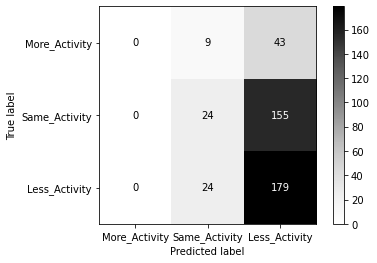

Logistic Model on Data Subset Complete in 85.401188 seconds
OrderedDict([('fit_intercept', True), ('solver', 'newton-cg')])


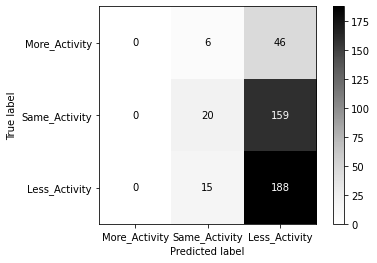

Logistic Model on Sig P Data Complete in 56.23434379999999 seconds
OrderedDict([('shrinkage', 0.03), ('solver', 'lsqr')])


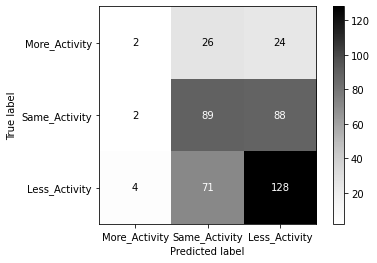

RDA Model on Full Data Complete in 723.9674726999999 seconds
OrderedDict([('shrinkage', 0.01), ('solver', 'lsqr')])


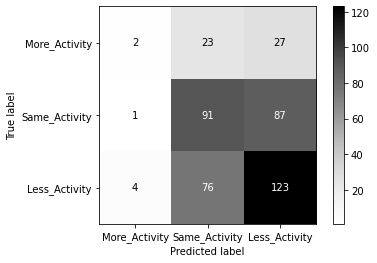

RDA Model on Data Subset Complete in 685.7742047999999 seconds
OrderedDict([('shrinkage', 0.1), ('solver', 'eigen')])


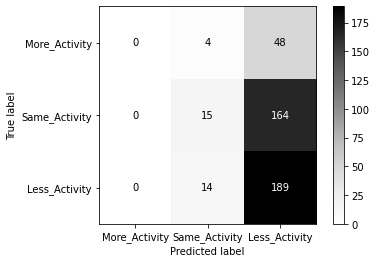

RDA Model on Data Subset Complete in 781.6292081000001 seconds
OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', 'log2'), ('n_estimators', 1000)])


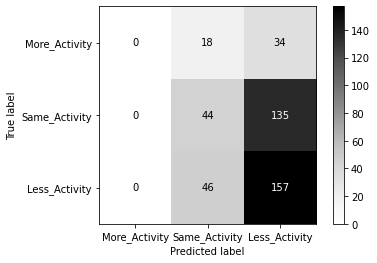

Random Forest Model on Data Subset Complete in 406.38789429999997 seconds
best coefficents for Boosted
[0.11003687 0.11666032 0.11826711 0.14767119 0.14262091 0.10106119
 0.11785984 0.00964239 0.00832919 0.00726215 0.00502916 0.00888528
 0.00732333 0.01207062 0.00437517 0.00686332 0.00770317 0.01146522
 0.00831839 0.01056843 0.00324824 0.00681879 0.00860228 0.01143656
 0.00788088]


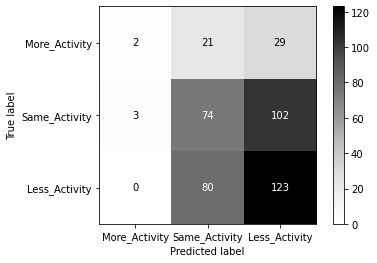

Boosted Trees Model on Full Dataset Complete in 1725.0996915 seconds
best coefficents for Boosted
[0.15794868 0.16973369 0.22719434 0.13937955 0.1547222  0.01051811
 0.01107924 0.00684245 0.00770155 0.01361094 0.00614889 0.00688738
 0.00904573 0.01368396 0.00719746 0.01370906 0.00489114 0.00659918
 0.011564   0.0134559  0.00808654]


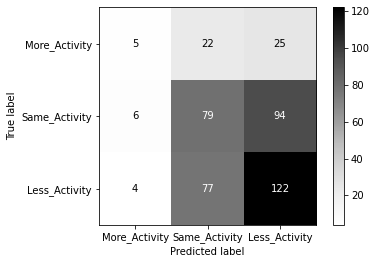

Boosted Trees Model on Data Subset Complete in 1485.2183583000005 seconds


In [11]:
#Soybeans Classfication
start = timer()
log_accuracy_part,log_sub_soy_params = run_logistic(xs_part,ys_class,graph=True)
end = timer()
print(f'Logistic Model on Data Subset Complete in {end-start} seconds')

start = timer()
log_accuracy_sig,log_sig_soy_params = run_logistic(xs_sig,ys_class,graph=True)
end = timer()
print(f'Logistic Model on Sig P Data Complete in {end-start} seconds')

start = timer()
rda_accuracy_full,rda_full_soy_params = run_RDA_classification(xs_full,ys_class,graph=True)
end = timer()
print(f'RDA Model on Full Data Complete in {end-start} seconds')

start = timer()
rda_accuracy_part,rda_sub_soy_params = run_RDA_classification(xs_part,ys_class,graph=True)
end = timer()
print(f'RDA Model on Data Subset Complete in {end-start} seconds')

start = timer()
rda_accuracy_sig,rda_sig_soy_params = run_RDA_classification(xs_sig,ys_class,graph=True)
end = timer()
print(f'RDA Model on Sig P Complete in {end-start} seconds')

start = timer()
rf_accuracy_part,rf_sub_soy_params = run_cross_validation_on_classification_RF(xs_part,ys_class,graph=True)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()
boost_accuracy_full,boo_full_soy_params = run_cross_validation_on_classification_Boost(xs_full,ys_class,graph=True)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()
boost_accuracy_part,boo_sub_soy_params = run_cross_validation_on_classification_Boost(xs_part,ys_class,graph=True)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

In [12]:
#Soybeans Classification Results
#create a data frame of the results for analysis
result_aa_list  = [['Logistic Run 1','Partial',log_accuracy_part]
                  ,['Logistic Run 2','SigP',log_accuracy_part]                   
                  ,['RDA Run 1','Full',rda_accuracy_full]
                  ,['RDA Run 2','Partial',rda_accuracy_part]
                  ,['RDA Run 3','Partial',rda_accuracy_sig]                   
                  ,['Random Forest Run 1','Partial',rf_accuracy_part]
                  ,['Boosted Trees Run 1','Full',boost_accuracy_full]
                  ,['Boosted Trees Run 2','Partial',boost_accuracy_part]]
results_above_average = pd.DataFrame(result_aa_list,columns=['Model_Name','Data_Used','Accuracy'])
results_above_average.sort_values(['Accuracy'],ascending=[False])

,Model_Name,Data_Used,Accuracy
2,RDA Run 1,Full,0.504281
3,RDA Run 2,Partial,0.497304
7,Boosted Trees Run 2,Partial,0.474654
4,RDA Run 3,Partial,0.469820
0,Logistic Run 1,Partial,0.467742
1,Logistic Run 2,SigP,0.467742
5,Random Forest Run 1,Partial,0.463134
6,Boosted Trees Run 1,Full,0.458525


OrderedDict([('fit_intercept', True), ('solver', 'liblinear')])


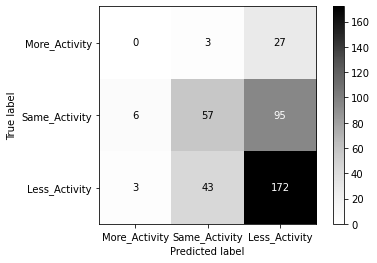

Logistic Model on Data Subset Complete in 72.72305179999967 seconds
OrderedDict([('fit_intercept', True), ('solver', 'liblinear')])


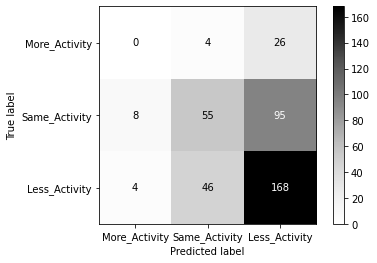

Logistic Model on Sig P Data Complete in 71.15515649999998 seconds
OrderedDict([('shrinkage', 0.76), ('solver', 'lsqr')])


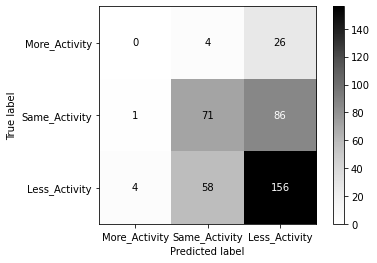

RDA Model on Full Data Complete in 821.0325309999998 seconds
OrderedDict([('shrinkage', 0.67), ('solver', 'lsqr')])


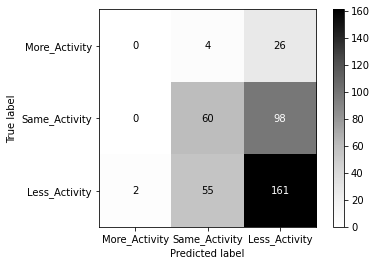

RDA Model on Data Subset Complete in 847.8725151999997 seconds
OrderedDict([('shrinkage', 0.98), ('solver', 'eigen')])


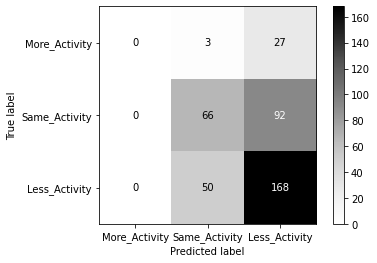

RDA Model on Data Subset Complete in 916.0940860000001 seconds
OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('max_features', 'sqrt'), ('n_estimators', 200)])


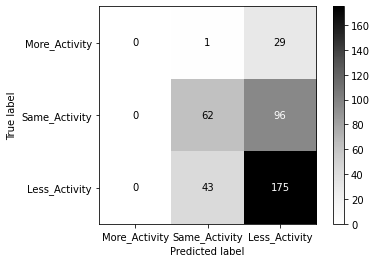

Random Forest Model on Data Subset Complete in 543.7128658999991 seconds
best coefficents for Boosted
[0.11874992 0.11131642 0.11413075 0.15020248 0.14299241 0.1042378
 0.12008316 0.00849764 0.00497778 0.00563175 0.00357305 0.00537635
 0.00304902 0.0149137  0.0099895  0.00795682 0.0080653  0.00817667
 0.00791481 0.00935118 0.00730597 0.00711705 0.00869152 0.00843394
 0.00926502]


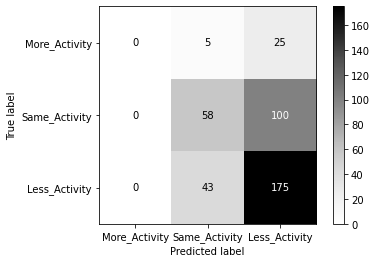

Boosted Trees Model on Full Dataset Complete in 1620.2390615999993 seconds
best coefficents for Boosted
[8.75720403e-02 8.11341987e-02 5.85815721e-01 7.63540985e-02
 1.13386908e-01 8.00949250e-04 1.10950482e-03 1.17278674e-02
 4.98488108e-03 2.59461313e-04 5.51201501e-03 5.73386392e-05
 1.82212770e-03 1.62740130e-03 7.03356672e-04 2.36457828e-03
 1.22852086e-03 8.19629264e-03 1.49339313e-03 1.01013205e-03
 1.28392130e-02]


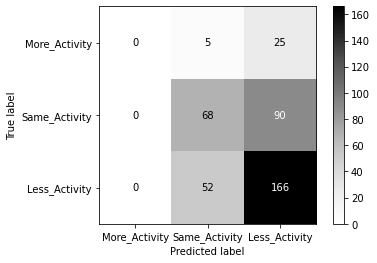

Boosted Trees Model on Data Subset Complete in 1158.4423982999997 seconds


In [13]:
#Corn Classfication
start = timer()
log_accuracy_part,log_sub_corn_params = run_logistic(xc_part,yc_class,graph=True)
end = timer()
print(f'Logistic Model on Data Subset Complete in {end-start} seconds')

start = timer()
log_accuracy_sig,log_sig_corn_params = run_logistic(xc_sig,yc_class,graph=True)
end = timer()
print(f'Logistic Model on Sig P Data Complete in {end-start} seconds')

start = timer()
rda_accuracy_full,rda_full_corn_params = run_RDA_classification(xc_full,yc_class,graph=True)
end = timer()
print(f'RDA Model on Full Data Complete in {end-start} seconds')

start = timer()
rda_accuracy_part,rda_sub_corn_params = run_RDA_classification(xc_part,yc_class,graph=True)
end = timer()
print(f'RDA Model on Data Subset Complete in {end-start} seconds')

start = timer()
rda_accuracy_sig,rda_sig_corn_params = run_RDA_classification(xc_sig,yc_class,graph=True)
end = timer()
print(f'RDA Model on Sig P Complete in {end-start} seconds')

start = timer()
rf_accuracy_part,rf_sub_corn_params = run_cross_validation_on_classification_RF(xc_part,yc_class,graph=True)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()
boost_accuracy_full,boo_full_corn_params = run_cross_validation_on_classification_Boost(xc_full,yc_class,graph=True)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()
boost_accuracy_part,boo_sub_corn_params = run_cross_validation_on_classification_Boost(xc_part,yc_class,graph=True)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

In [14]:
#Corn  Classification Results
#create a data frame of the results for analysis
c_result_aa_list  = [['Logistic Run 1','Partial',log_accuracy_part]
                  ,['Logistic Run 2','SigP',log_accuracy_part]                   
                  ,['RDA Run 1','Full',rda_accuracy_full]
                  ,['RDA Run 2','Partial',rda_accuracy_part]
                  ,['RDA Run 3','SigP',rda_accuracy_sig]                   
                  ,['Random Forest Run 1','Partial',rf_accuracy_part]
                  ,['Boosted Trees Run 1','Full',boost_accuracy_full]
                  ,['Boosted Trees Run 2','Partial',boost_accuracy_part]]
results_above_average = pd.DataFrame(c_result_aa_list,columns=['Model','Dataset','Accuracy'])
results_above_average.sort_values(['Accuracy'],ascending=[False])

,Model_Name,Data_Used,Accuracy
5,Random Forest Run 1,Partial,0.583744
4,RDA Run 3,SigP,0.576402
7,Boosted Trees Run 2,Partial,0.576355
6,Boosted Trees Run 1,Full,0.573892
0,Logistic Run 1,Partial,0.564039
1,Logistic Run 2,SigP,0.564039
2,RDA Run 1,Full,0.558963
3,RDA Run 2,Partial,0.543902


In [15]:
full_end = timer()
print(f'time elapsed in minutes = {(full_end-full_start)/60}')

time elapsed in minutes = 200.023990045
